In [1]:
import numpy
from numba import jit

$$
p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2}{2(\Delta x^2+\Delta y^2)}-\frac{\rho\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)} \times$$

$$\left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\right. $$

$$ -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\left.\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]$$

In [2]:
def bracket_term_ppe(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (
        rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                         (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                    2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                         (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) -
                        ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2)
                    )

    return b


In [8]:
b = numpy.random.random((5, 5))
u = numpy.random.random((5, 5))
v = numpy.zeros((5, 5))
dx = 0.1
dy = 0.1
dt = 0.1
rho = 1.
bracket_term_ppe(b, rho, dt, u, v, dx, dy)

array([[  0.68808125,   0.81454171,   0.152018  ,   0.64747148,   0.5375032 ],
       [  0.37384305, -62.43740275, -17.68188508,  11.12265368,
          0.29054923],
       [  0.51508587,   8.37885555,  18.87999804, -16.24454542,
          0.27188346],
       [  0.163213  , -21.25562993, -51.92659062,   8.34630307,
          0.96139706],
       [  0.66869754,   0.79458091,   0.62980467,   0.958411  ,
          0.84077029]])

In [6]:
%%timeit
b = numpy.random.random((500,500))
u = numpy.random.random((500,500))
v = numpy.zeros((500,500))
dx = 0.1
dy = 0.1
dt = 0.1
rho = 1.
bracket_term_ppe(b, rho, dt, u, v, dx, dy)

100 loops, best of 3: 13.1 ms per loop


In [3]:
bracket_term_ppe_jit = jit(bracket_term_ppe)

In [9]:
%%timeit
b = numpy.random.random((500,500))
u = numpy.random.random((500,500))
v = numpy.zeros((500,500))
dx = 0.1
dy = 0.1
dt = 0.1
rho = 1.
bracket_term_ppe_jit(b, rho, dt, u, v, dx, dy)

100 loops, best of 3: 13.5 ms per loop


$$
p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2}{2(\Delta x^2+\Delta y^2)}-\frac{\rho\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)} \times$$

$$\left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\right. $$

$$ -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\left.\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]$$

In [25]:
@jit(nopython=True)
def pressure_poisson(p, dx, dy, b, nit=50):
    #pn = numpy.empty_like(p)
    pn = p.copy()
    J, I = b.shape
    
    for q in range(nit): 
        pn = p.copy()
        for j in range(1, J - 1):
            for i in range(1, I - 1):
                p[j, i] = (((pn[j, i + 1] + pn[j, i - 1]) * dy**2 + 
                        (pn[j + 1, i] + pn[j - 1, i]) * dx**2) /
                        (2 * (dx**2 + dy**2)) -
                        dx**2 * dy**2 / (2 * (dx**2 + dy**2)) *
                        b[j, i])

        for j in range(J):
            p[j, 0] = p[j, 1]
            p[j, -1] = p[j, -2]
            
        for i in range(I):
            p[0, i] = p[1, i]
            p[-1, i] = 0
#          p[:, -1] = p[:, -2] #dp/dy = 0 at x = 2
#          p[0, :] = p[1, :] #dp/dy = 0 at y = 0
#          p[:, 0] = p[:, 1] #dp/dx = 0 at x = 0
#          p[-1, :] = 0 #p = 0 at y = 2
        
    return p

In [9]:
b.shape

(5, 5)

In [10]:
b = bracket_term_ppe(b, rho, dt, u, v, dx, dy)

In [11]:
p = numpy.random.random((5,5))

In [14]:
pressure_poisson(p, dx, dy, b)

array([[ 1.0295451 ,  1.0295451 ,  0.79166086,  0.61092036,  0.61092036],
       [ 1.0295451 ,  1.0295451 ,  0.79166086,  0.61092036,  0.61092036],
       [ 0.64740251,  0.64740251,  0.56204545,  0.54575357,  0.54575357],
       [ 0.43789171,  0.43789171,  0.455651  ,  0.30533562,  0.30533562],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [11]:
# pressure_poisson.inspect_types()

The momentum equation in the $u$ direction:

$$
u_{i,j}^{n+1} = u_{i,j}^{n} - u_{i,j}^{n}\frac{\Delta t}{\Delta x}(u_{i,j}^{n}-u_{i-1,j}^{n})
- v_{i,j}^{n}\frac{\Delta t}{\Delta y}(u_{i,j}^{n}-u_{i,j-1}^{n})$$
$$-\frac{\Delta t}{\rho 2\Delta x}(p_{i+1,j}^{n}-p_{i-1,j}^{n})
+\nu\left(\frac{\Delta t}{\Delta x^2}(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n})\right.
+\left.\frac{\Delta t}{\Delta y^2}(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n})\right)
$$

The momentum equation in the $v$ direction:

$$v_{i,j}^{n+1} = v_{i,j}^{n}-u_{i,j}^{n}\frac{\Delta t}{\Delta x}(v_{i,j}^{n}-v_{i-1,j}^{n})
- v_{i,j}^{n}\frac{\Delta t}{\Delta y}(v_{i,j}^{n}-v_{i,j-1}^{n})$$
$$
-\frac{\Delta t}{\rho 2\Delta y}(p_{i,j+1}^{n}-p_{i,j-1}^{n})
+\nu\left(\frac{\Delta t}{\Delta x^2}(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n})\right.
+\left.\frac{\Delta t}{\Delta y^2}(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n})\right)$$

In [13]:
@jit(nopython=True)
def mycopy(u, un):
    J, I = u.shape
    for j in range(J):
        for i in range(I):
            un[j, i] = u[j, i]
            
    return un

In [24]:
@jit(nopython = True)
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    J, I = p.shape

    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = bracket_term_ppe_jit(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, 100)
        
        for j in range(1, J - 1):
            for i in range(1, I - 1):
                u[j, i] = (un[j, i] -
                                un[j, i] * dt / dx *
                                (un[j, i] - un[j, i - 1]) -
                                vn[j, i] * dt / dy *
                                (un[j, i] - un[j - 1, i]) -
                                dt / (2 * rho * dx) *
                                (p[j, i + 1] - p[j, i - 1]) +
                                nu * dt *
                                (1 / dx**2 *
                                 (un[j, i + 1] - 2 * un[j, i] + un[j, i - 1]) +
                                1 / dy**2 *
                                 (un[j + 1, i] - 2 * un[j, i] + un[j - 1, i])))

                v[j, i] = (vn[j, i] -
                                un[j, i] * dt / dx *
                                (vn[j, i] - vn[j, i - 1]) -
                                vn[j, i] * dt / dy *
                                (vn[j, i] - vn[j - 1, i]) -
                                dt / (2 * rho * dy) *
                                (p[j + 1, i] - p[j - 1, i]) +
                                nu * dt *
                                (1 / dx**2 *
                                 (vn[j, i + 1] - 2 * vn[j, i] + vn[j, i - 1]) +
                                1 / dy**2 *
                                 (vn[j + 1, i] - 2 * vn[j, i] +vn[j - 1, i])))
                
        

        for j in range(J):
            u[j, 0] = 0
            u[j, -1] = 0
            v[j, 0] = 0
            v[j, -1] = 0
            
        for i in range(I):
            u[-1, i] = 1    #set velocity on cavity lid equal to 1
            v[0, i] = 0
            v[-1, i]=0
            u[0, i] = 0
            


    return u, v, p

In [26]:

nx = ny = 101
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))

dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
rho = 1
nu = 0.1
dt = .0005

nt = 400
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

In [17]:
from matplotlib import pyplot, cm
%matplotlib inline

In [18]:
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

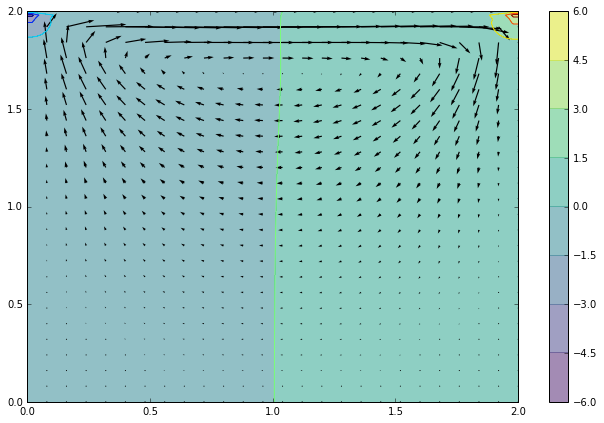

In [19]:
quiver_skip = qs = 4
pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p)
pyplot.quiver(X[::qs, ::qs], Y[::qs, ::qs], u[::qs, ::qs], v[::qs, ::qs])

In [20]:
p

array([[-0.04902058, -0.04902058, -0.04917156, ...,  0.04853162,
         0.04837984,  0.04837984],
       [-0.04902058, -0.04902058, -0.04917156, ...,  0.04853162,
         0.04837984,  0.04837984],
       [-0.0488694 , -0.0488694 , -0.04902049, ...,  0.04837937,
         0.04822748,  0.04822748],
       ..., 
       [-3.5261694 , -3.5261694 , -2.60945753, ...,  2.81743975,
         3.77026832,  3.77026832],
       [-4.95522315, -4.95522315, -3.3104986 , ...,  3.5070443 ,
         5.18823131,  5.18823131],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [21]:
def run_cavity():
    nx = ny = 101
    u = numpy.zeros((ny, nx))
    v = numpy.zeros((ny, nx))
    p = numpy.zeros((ny, nx))
    b = numpy.zeros((ny, nx))

    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    rho = 1
    nu = 0.1
    dt = .0001

    nt = 800
    u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

In [16]:
%load_ext line_profiler

In [22]:
%lprun -f cavity_flow run_cavity()

In [27]:
%timeit run_cavity()

1 loop, best of 3: 3.51 s per loop


In [22]:
@jit(nopython=True)
def bracket_term_ppe_jit(b, rho, dt, u, v, dx, dy):
    J, I = b.shape
    for j in range(1, J - 1):
        for i in range(1, I - 1):
            b[j, i] = (
                rho * (1 / dt * ((u[j, i + 1] - u[j, i - 1]) / (2 * dx) +
                                 (v[j + 1, i] - v[j - 1, i]) / (2 * dy)) -
                                ((u[j, i + 1] - u[j, i - 1]) / (2 * dx))**2 -
                            2 * ((u[j + 1, i] - u[j - 1, i]) / (2 * dy) *
                                 (v[j, i + 1] - v[j, i - 1]) / (2 * dx)) -
                                ((v[j + 1, i] - v[j - 1, i]) / (2 * dy))**2)
                            )

    return b


In [15]:
%timeit run_cavity()

1 loop, best of 3: 3.74 s per loop
